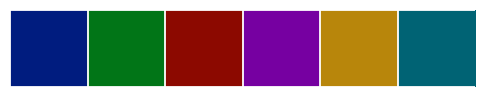

In [1]:
%matplotlib inline
import seaborn 
seaborn.set(
    context="talk", palette=seaborn.color_palette('dark')
)

from matplotlib import pylab
seaborn.palplot(
    seaborn.color_palette("dark")
)

In [2]:
import copy
import pathlib
import numpy as np

import pandas

from matplotlib import pylab

from multiprocessing import Pool

from kaskady2.analyze.profile import *
from kaskady2.analyze.fits import *
from kaskady2.analyze.profile_fits import *
from kaskady2.loader.reader import CascadeSetLoader



In [3]:
cascades = CascadeSetLoader.find_cascades(
  pathlib.Path('/home/jb/kaskady-data/g4-production')
)

In [4]:
fits_dir = pathlib.Path("/tmp/fits-longitudinal")

fits_dir.mkdir(exist_ok=True)


In [5]:
class LongFitPerformer(FitPerformer): 
      
    def __init__(self, loader): 
        super().__init__(copy.copy(loader.config))
        self.loader=loader
        
    def get_fit_data(self) -> FitData:
        geometry = self.loader.main_geometry   
        avg_profile = geometry.get_longitudinal_average_profile()
        return FitDataWrapper(
            LongitudinalProfileFitData(avg_profile), 
            fit_until_deposition_reaches=0.9995)

    def get_fit_function(self) -> FitFunction:
        return LongitudinalProfileFitFunction()

def doFit(loader):
    performer = LongFitPerformer(loader)
    result = performer.do_fit()
    data = result.fit_data
    config = copy.copy(result.context)
    try: 
        pylab.clf()

        pylab.plot(
          data.xdata, 
          data.ydata, 
          label="Profile"
        )

        pylab.plot(
            data.xdata, result.fitted_ydata, 
            label="Fit using 5-parametric function"
        )

        pylab.xlabel("Cascade depth [rad. len.]")
        pylab.ylabel("Energy deposition [MeV]")

        pylab.title(
            "$E_\gamma={config.run_info.energy_mev}MeV$  "  
            "$E_{{c.o.}}={config.ecuts.energy_mev}MeV$  "
            "$N_{{inc}}={config.run_info.incidents}$  "
            "Material is:  {config.material.name_pretty}".format(
                config=config
            ), 
            fontsize=12)
        pylab.suptitle(
            "Longitudinal profile", fontsize=18
        )

#         pylab.ylim(, 1.1*np.max(data.ydata))
        pylab.legend()
        pylab.savefig(str(fits_dir / "{}.png".format("-".join((map(str, (
          config.run_info.energy_mev , config.material.name, config.ecuts.energy_mev)))
        ))), dpi=150)       
        pylab.yscale('log')
        pylab.savefig(str(fits_dir / "{}-log.png".format("-".join((map(str, (
          config.run_info.energy_mev , config.material.name, config.ecuts.energy_mev)))
        ))), dpi=150) 
    except: 
        result.context.plot_error = True
        

    return result

    

FitResultsDescription(context=<Config version=(1, 1, 0) run_info=RunInfo(particle=<InitialParticle.GAMMA: 'GAMMA'>, incidents=15000, energy_mev=11000) material=Material(name='G4_BGO', name_pretty='BGO', w_coeff=17.0779049125405, density_g_cm3=7.13, rad_len_mm=11.18008168663319) cuts=Cuts(type=<CutsType.G4Cuts: 'G4Cuts'>, energy_kev=3000, energy_mev='3.0')>, fit_ok=True, absolute_sigma=True, params=array([ 10.15069053,   8.31765876,   0.55146859,   5.05521021,   0.9356723 ]), params_stddev=array([ 0.21808162,  0.01467979,  0.00084614,  0.0246706 ,  0.00165822]), fit_data=<kaskady2.analyze.profile_fits.longitudinal.FitDataWrapper object at 0x7fd9b6eef390>, fitted_ydata=array([   3.41659539,    3.40589685,    3.97720503,    4.8269902 ,
          5.90646155,    7.20509319,    8.72141972,   10.45554041,
         12.40658267,   14.57174339,   16.94595621,   19.52185039,
         22.28986155,   25.23842668,   28.35422593,   31.62244854,
         35.0270676 ,   38.5511133 ,   42.17693738,   45

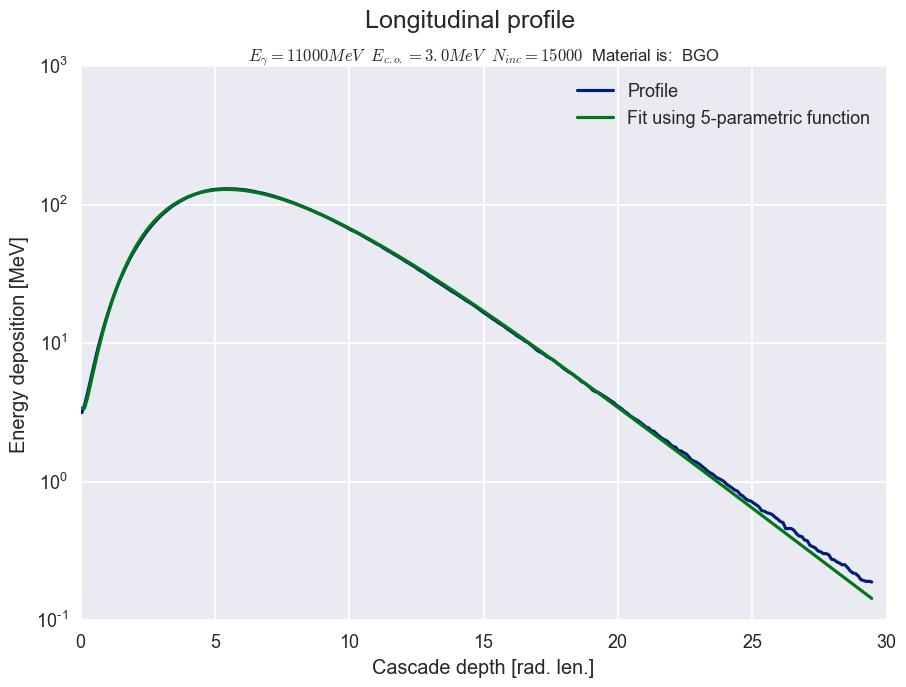

In [6]:
doFit(cascades[0])

In [7]:
# Plots look mangled when executing it in Pool. Probably some race-condition bug 
# somewhere. Doing these fits sequentially is, well slow but fast enough.

# pool = Pool(processes=3, maxtasksperchild=1)     
# result = pool.map_async(doFit, cascades)
# result.wait(timeout=320)

In [8]:
# result.successful()

In [9]:
# results = result.get()

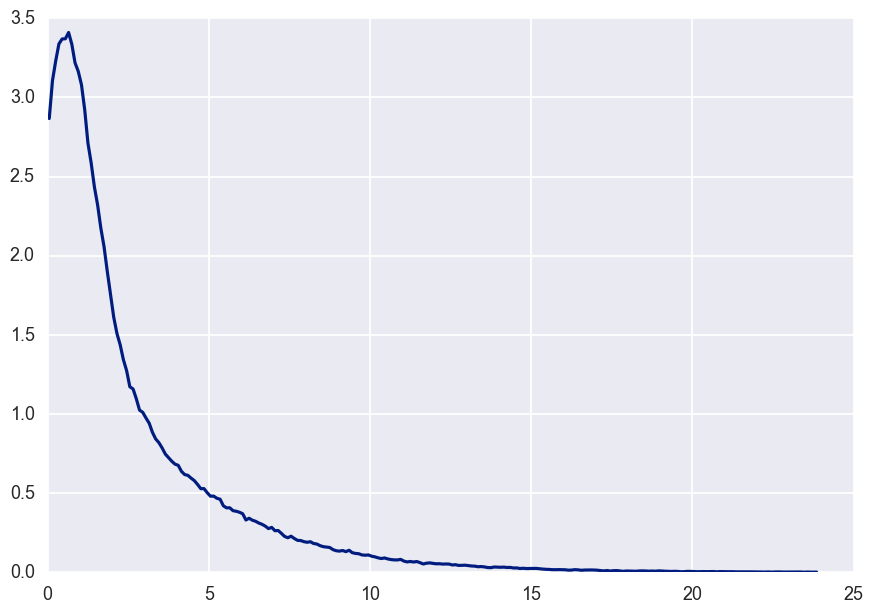

In [10]:
results = [doFit(c) for c in cascades]

In [11]:
fsm = FitSetManager(
    index_attrs=('material', 'ecuts_kev', 'energy_mev'), 
    expected_params=["alpha", "beta", "delta", "gamma", "epsilon"]
)

In [12]:
fsm.add_results(results)
fsm.make_frame()

/home/jb/programs/kaskady2.0/kaskady2/analyze/fits/helpers.py:183: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  self.frame = table.sort(index_attrs).set_index(drop=False, keys=index_attrs)


In [13]:
fsm.save("/home/jb/kaskady-data/results/profiles.bin")

In [14]:
fsm.frame.to_excel('/tmp/fits-long.xls')

In [15]:
fsm.frame['chisq sum']

material   ecuts_kev  energy_mev
BGO        600        100                         None
                      120                         None
                      145            9.608274564537698
                      175            8.842008929840429
                      210            7.523412953798157
                      255            7.057395657752851
                      310            5.893054302985028
                      375            8.495029013340305
                      455            7.598090545883415
                      555            7.792674938955302
                      680            7.791929580836148
                      875            8.146585644403602
                      1125           7.928357393090756
                      1375           9.581501772392375
                      1625           9.142354773761593
                      1875           9.479801623140947
                      2125           9.296384651357183
                      2375      